In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from textblob import TextBlob

from scipy import stats

plt.rcParams.update({'font.size': 18})
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_columns', False)

import warnings
warnings.filterwarnings('ignore')

In [538]:
df = pd.read_csv('playlist_revision_v02.txt', sep="	")

Column Name : Description
- **playlist_uri:** The key, uri of the playlist
- **owner:** Playlist owner, username
- **streams:** Number of streams from playlist today
- **stream30s:** Number of streams over 30 seconds from playlist today
- **dau:** Number of Daily Active Users, i.e. users with a stream over 30 seconds from playlist today
- **wau:** Number of Weekly Active Users, i.e. users with a stream over 30 seconds from playlist in past week
- **mau:** Number of Monthly Active Users, i.e. users with a stream over 30 seconds from playlist in past month
- **mau_previous_months:** Number of Monthly Active Users in the month prior to this one
- **mau_both_months:** Number of users that were active on the playlist both this and the previous month
- **users:** Number of users streaming (all streams) from this playlist this month
- **skippers:** Number of users who skipped more than 90 percent of their streams today
- **owner_country:** Country of the playlist owner
- **n_tracks:** Number of tracks in playlist
- **n_local_tracks:** Change in number of tracks on playlist since yesterday
- **n_artists:** Number of unique artists in playlist
- **n_albums:** Number of unique albums in playlist
- **monthly_stream30s:** Number of streams over 30 seconds this month
- **monthly_owner_stream30s:** Number of streams over 30 seconds by playlist owner this month
- **tokens:** List of playlist title tokens, stopwords and punctuation removed
- **genre_1:** No. 1 Genre by weight of playlist tracks, from Gracenote metadata
- **genre_2:** No. 2 Genre by weight of playlist tracks, from Gracenote metadata
- **genre_3:** No. 3 Genre by weight of playlist tracks, from Gracenote metadata
- **mood_1:** No. 1 Mood by weight of playlist tracks, from Gracenote metadata
- **mood_2:** No. 2 Mood by weight of playlist tracks, from Gracenote metadata
- **mood_3:** No. 3 Mood by weight of playlist tracks, from Gracenote metadata

## Explore data

In [539]:
df.info() # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403366 entries, 0 to 403365
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   playlist_uri             403366 non-null  object
 1   owner                    403366 non-null  object
 2   streams                  403366 non-null  int64 
 3   stream30s                403366 non-null  int64 
 4   dau                      403366 non-null  int64 
 5   wau                      403366 non-null  int64 
 6   mau                      403366 non-null  int64 
 7   mau_previous_month       403366 non-null  int64 
 8   mau_both_months          403366 non-null  int64 
 9   users                    403366 non-null  int64 
 10  skippers                 403366 non-null  int64 
 11  owner_country            403366 non-null  object
 12  n_tracks                 403366 non-null  int64 
 13  n_local_tracks           403366 non-null  int64 
 14  n_artists           

### Remove owner

In [540]:
df.owner.value_counts()

spotify                             399
6987037f34b5cee787a1a5e8de9b2689     48
a5add6d0d5fbebb01abb2fbe7e47208d     47
f54f32d1c706754a70f8392aa1dbad46     44
4a03268bef1505a49f8b3eced879f311     43
                                   ... 
f212d60273435fed3dd79d93b780365b      1
42cef02b077b8c103935359adb4ce08b      1
e0ec50d6bc743e13ceb4cc5060de0748      1
82f1012bc933fa569a6735be50d14c04      1
ea99c2efd8f5fee79d6b79fa81affb8f      1
Name: owner, Length: 314899, dtype: int64

In [541]:
df.owner = df.owner.astype(str)

In [542]:
df['clean_monthly_stream30s'] = df.monthly_stream30s - df.monthly_owner_stream30s

In [543]:
# list_quantiles = []
# for col in ['n_tracks', 'n_albums', 'n_artists',]:
#     q1 = df[col].quantile(.01)
#     q3 = df[col].quantile(.99)
#     print(col, q1, q3)
#     list_quantiles.append([col, q1, q3])


list_quantiles = []
for col in ['clean_monthly_stream30s',]:
    q1 = df[col].quantile(.01)
    q3 = df[col].quantile(.99)
    print(col, q1, q3)
    list_quantiles.append([col, q1, q3])

clean_monthly_stream30s 1.0 2419.6999999999534


In [544]:
for el in list_quantiles:
    col = el[0]
    q1 = el[1]
    q3 = el[2]
    print(col, q1, q3)
    df = df.loc[(df[col]>q1) & (df[col]<q3)]

clean_monthly_stream30s 1.0 2419.6999999999534


<AxesSubplot:>

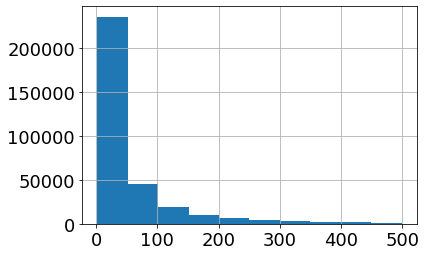

In [606]:
df.loc[df['clean_monthly_stream30s']<500].clean_monthly_stream30s.hist()

In [545]:
# df = df.loc[df.clean_monthly_stream30s<df.clean_monthly_stream30s.quantile(.99)]

In [546]:
df[['playlist_uri', 'mau', 'clean_monthly_stream30s']].drop_duplicates().corr()

,mau,clean_monthly_stream30s
mau,1.000000,0.718897
clean_monthly_stream30s,0.718897,1.000000


In [386]:
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.regplot(x=df.mau, y=df.clean_monthly_stream30s, color='lime')
# ax.ticklabel_format(style='plain')
# plt.ylabel('MAU')
# plt.xlabel('Monthly streams>30sec (exlcuded owners)')

In [387]:
# fig, ax = plt.subplots(figsize=(5, 5))
# sns.regplot(x=df.wau, y=df.clean_monthly_stream30s, color='lime')
# ax.ticklabel_format(style='plain')
# plt.ylabel('WAU')
# plt.xlabel('Monthly streams>30sec (exlcuded owners)')

In [388]:
# fig, ax = plt.subplots(figsize=(5, 5))
# sns.regplot(x=df.dau, y=df.clean_monthly_stream30s, color='lime')
# ax.ticklabel_format(style='plain')
# plt.ylabel('DAU')
# plt.xlabel('Monthly streams>30sec (exlcuded owners)')

### Additional success metrics

In [389]:
# df = df.loc[df.mau_previous_month>0]

In [390]:
df['increase_previous_mau'] = (df.mau_previous_month*9)/10
df['success_increase'] = np.where(df.mau>=df.increase_previous_mau,1,0)
df['monthly_streams30_rank'] = df['clean_monthly_stream30s'].rank(pct=True)

df['success'] = np.where(
    (df.monthly_streams30_rank>=0.9) & 
    (df.success_increase==1), 1, 0)

In [391]:
df.loc[df.mau_previous_month>0].playlist_uri.nunique()/df.playlist_uri.nunique()

0.9070104930997533

### Extraction features linked to successful palylist

In [547]:
df["genre_1"] = df["genre_1"].apply(lambda z: z.replace("-","No associated Genre"))
df["mood_1"] = df["mood_1"].apply(lambda z: z.replace("-","No associated Genre"))

In [548]:
df['avg_monthly_stream30_genre'] = df.groupby('genre_1').clean_monthly_stream30s.transform(np.mean)
df['avg_monthly_stream30_mood'] = df.groupby('mood_1').clean_monthly_stream30s.transform(np.mean)

In [549]:
# df['perc_genre'] = df.groupby('genre_1').playlist_uri\
# .transform(lambda x: (x.nunique()/df.playlist_uri.nunique())*100)
# df['perc_mood'] = df.groupby('mood_1').playlist_uri\
# .transform(lambda x: (x.nunique()/df.playlist_uri.nunique())*100)

Text(0.5, 0, 'AVG Monthly streams>30sec (exlcuded owners)')

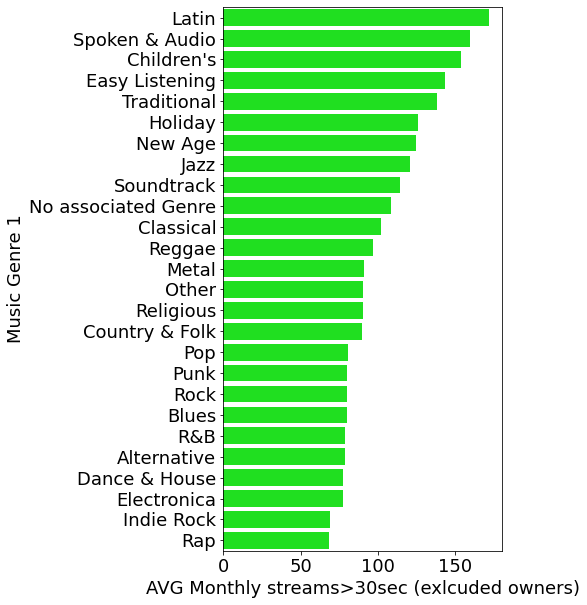

In [550]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(y="genre_1", x="avg_monthly_stream30_genre", 
            data=df.sort_values(by='avg_monthly_stream30_genre', ascending=False),\
           ax=ax, color='lime')
plt.ylabel('Music Genre 1')
plt.xlabel('AVG Monthly streams>30sec (exlcuded owners)')

In [551]:
df[["genre_1","avg_monthly_stream30_genre"]].drop_duplicates()\
.sort_values(by='avg_monthly_stream30_genre', ascending=False).genre_1[:5]

2               Latin
67     Spoken & Audio
138        Children's
103    Easy Listening
99        Traditional
Name: genre_1, dtype: object

Text(0.5, 0, 'AVG Monthly streams>30sec (exlcuded owners)')

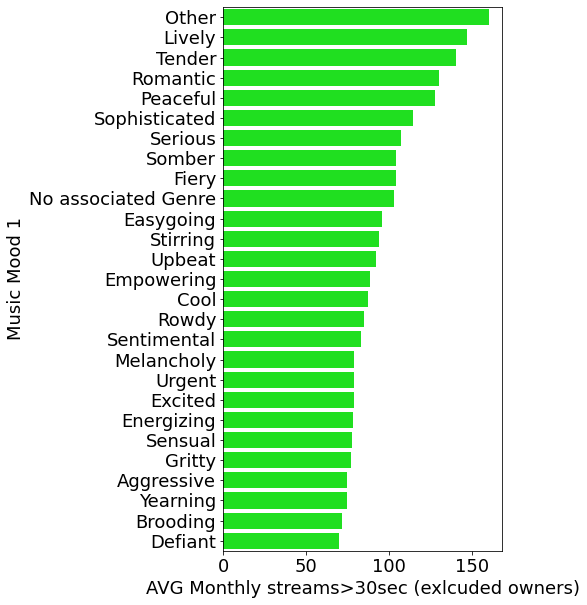

In [552]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(y="mood_1", x="avg_monthly_stream30_mood", data=df.sort_values(by='avg_monthly_stream30_mood', ascending=False),\
           ax=ax, color='lime')
plt.ylabel('Music Mood 1')
plt.xlabel('AVG Monthly streams>30sec (exlcuded owners)')

## User motivation -> tockens

1. motivation of user -> number of tockens
2. sentiment score -> mood sentiment average

In [553]:
df['list_tokens'] = df.tokens.astype(str).apply(lambda x: x.strip('][').split(', '))

In [597]:
df['num_tockens'] = df['list_tokens'].apply(lambda x: len(x) if x!=[''] else 0)

In [555]:
# df['num_tockens_bin'] = None
# df.loc[df['num_tockens']<2, 'num_tockens_bin'] = 'below 2'
# df.loc[(df['num_tockens']>=2) & (df['num_tockens']<5), 'num_tockens_bin'] = 'higher/equal 2 and below 5'
# df.loc[(df['num_tockens']>=5), 'num_tockens_bin'] = 'higher/equal than 5'

In [598]:
df['num_tokens_bins'] = pd.qcut(df['num_tockens'], 3,
                labels=['0-1 token', '2 tokens', 'more/equal 3 tokens'])

In [599]:
df['num_tokens_bins'].unique().tolist()

['more/equal 3 tokens', '2 tokens', '0-1 token']

Text(0.5, 0, 'AVG Monthly streams>30sec (exlcuded owners)')

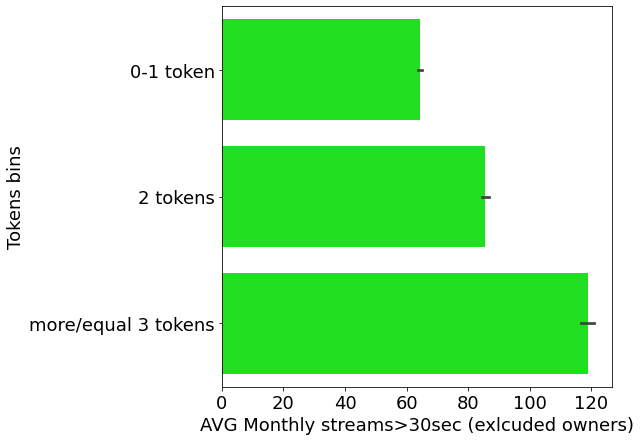

In [601]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(y=df.num_tokens_bins, x=df.clean_monthly_stream30s, color='lime',
           order=['0-1 token', '2 tokens', 'more/equal 3 tokens'])
plt.ylabel('Tokens bins')
plt.xlabel('AVG Monthly streams>30sec (exlcuded owners)')

In [558]:
def get_sentiment_score(text):
    blob = TextBlob(text.strip("]["))
#     print(blob)
    blob = blob.replace('"', '')
#     print(blob)
    sentiment=blob.sentiment.polarity
#     print(sentiment)
    return(sentiment)

In [559]:
df['sentiment_score'] = df['tokens'].apply(lambda x: get_sentiment_score(x))

In [560]:
df.loc[df['sentiment_score']>.7][['sentiment_score', 'list_tokens']].head(10)

,sentiment_score,list_tokens
8,0.800000,"[""fly""]"
83,1.000000,"[""best"", ""play"", ""list"", ""ever""]"
115,1.000000,"[""best"", ""album"", ""closing"", ""tracks""]"
165,0.750000,"[""better"", ""best""]"
169,1.000000,"[""best""]"
208,0.800000,"[""push"", ""happy"", ""button""]"
309,1.000000,"[""best"", ""songs"", ""ray""]"
399,1.000000,"[""best""]"
422,0.750000,"[""country"", ""latest"", ""greatest""]"
485,0.800000,"[""great""]"


In [561]:
df.loc[df['sentiment_score']<-0.7][['sentiment_score', 'list_tokens']].head(10)

,sentiment_score,list_tokens
56,-0.714286,"[""sick"", ""beats""]"
1473,-1.000000,"[""uniformity"", ""boring""]"
2958,-0.800000,"[""guaranteed"", ""something"", ""hate""]"
4140,-1.000000,"[""terrible"", ""rap"", ""tony"", ""phil""]"
5249,-1.000000,"[""resident"", ""evil""]"
5806,-1.000000,"[""pop"", ""evil""]"
7042,-1.000000,"[""south"", ""france"", ""another"", ""boring"", ""sunr..."
7465,-1.000000,"[""horrible""]"
9144,-1.000000,"[""drake"", ""worst"", ""behavior""]"
10331,-0.800000,"[""hate"", ""rap"", ""music""]"


In [562]:
df['sentiment_score_bin'] = None
df.loc[df['sentiment_score']<=-0.5, 'sentiment_score_bin'] = 'below/equal-0.5'
df.loc[(df['sentiment_score']>-0.5) & (df['sentiment_score']>=0), 'sentiment_score_bin'] = 'higher -0.5 and below/equal 0'
df.loc[(df['sentiment_score']>0) & (df['sentiment_score']<=0.5), 'sentiment_score_bin'] = 'higher 0 and  below/equal 0.5'
df.loc[(df['sentiment_score']>0.5), 'sentiment_score_bin'] = 'higher 0.5'

Text(0.5, 0, 'AVG Monthly streams>30sec (exlcuded owners)')

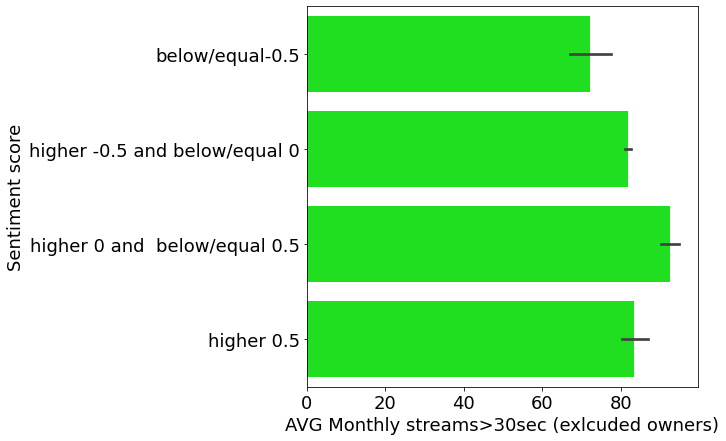

In [563]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(y=df.sentiment_score_bin, x=df.clean_monthly_stream30s, color='lime',
           order=['below/equal-0.5', 'higher -0.5 and below/equal 0',
                  'higher 0 and  below/equal 0.5', 'higher 0.5'])
# plt.xticks(rotation=60)
plt.ylabel('Sentiment score')
plt.xlabel('AVG Monthly streams>30sec (exlcuded owners)')

## Playlist variation:

1. number of albumns
2. number of artists
3. number of tracks
4. number of genres
5. number of moods

In [569]:
list_quantiles = []
for col in ['n_tracks', 'n_albums', 'n_artists',]:
    q1 = df[col].quantile(.01)
    q3 = df[col].quantile(.99)
    print(col, q1, q3)
    list_quantiles.append([col, q1, q3])


n_tracks 6.0 1862.0
n_albums 1.0 615.0
n_artists 1.0 588.0


In [570]:
for el in list_quantiles:
    col = el[0]
    q1 = el[1]
    q3 = el[2]
    print(col, q1, q3)
    df = df.loc[(df[col]>q1) & (df[col]<q3)]

n_tracks 6.0 1862.0
n_albums 1.0 615.0
n_artists 1.0 588.0


In [612]:
df['avg_monthly_stream30_track'] = df.groupby('n_tracks').clean_monthly_stream30s.transform(np.mean)
df['avg_monthly_stream30_album'] = df.groupby('n_albums').clean_monthly_stream30s.transform(np.mean)
df['avg_monthly_stream30_artist'] = df.groupby('n_artists').clean_monthly_stream30s.transform(np.mean)

In [617]:
df['sum_monthly_stream30_track'] = df.groupby('n_tracks').clean_monthly_stream30s.transform(sum)
df['sum_monthly_stream30_album'] = df.groupby('n_albums').clean_monthly_stream30s.transform(sum)
df['sum_monthly_stream30_artist'] = df.groupby('n_artists').clean_monthly_stream30s.transform(sum)

Text(0.5, 15.440000000000012, '#tracks')

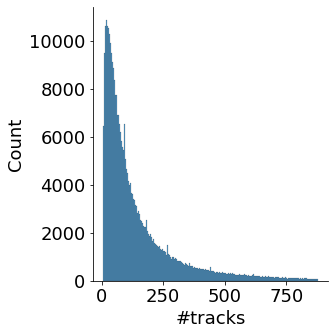

In [626]:
sns.displot(df.loc[df.n_tracks<df.n_tracks.quantile(quantile)].n_tracks)
plt.xlabel('#tracks')

Text(0.5, 15.440000000000012, '#artists')

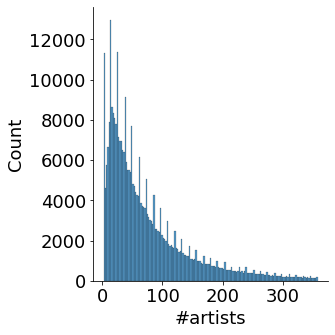

In [631]:
sns.displot(df.loc[df.n_artists<df.n_artists.quantile(quantile)].n_artists)
plt.xlabel('#artists')

Text(0.5, 15.440000000000012, '#albums')

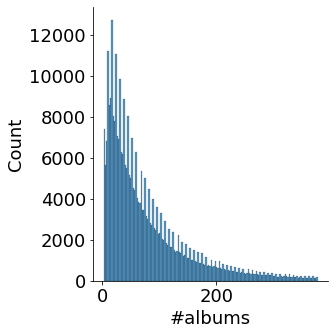

In [633]:
sns.displot(df.loc[df.n_albums<df.n_albums.quantile(quantile)].n_albums)
plt.xlabel('#albums')

<AxesSubplot:xlabel='clean_monthly_stream30s', ylabel='Density'>

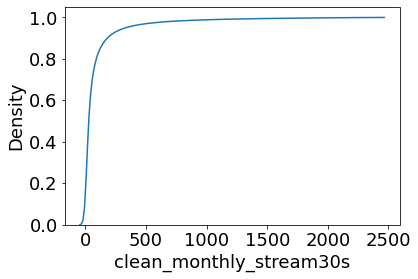

In [629]:
sns.kdeplot(
    data=df, x="clean_monthly_stream30s", 
    cumulative=True, common_norm=False, common_grid=True,
)

Text(0.5, 0, '#tracks')

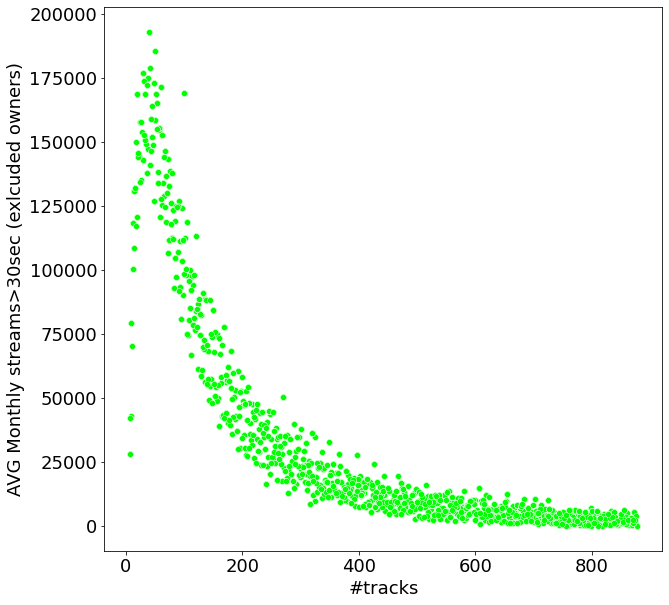

In [624]:
fig, ax = plt.subplots( figsize=(10, 10), sharey=True)
sns.scatterplot(x=df.loc[df.n_tracks<df.n_tracks.quantile(quantile)].n_tracks, 
            y=df.loc[df.n_tracks<df.n_tracks.quantile(quantile)].sum_monthly_stream30_track
           , color='lime', ax=ax, ci=None)
plt.ylabel('AVG Monthly streams>30sec (exlcuded owners)')
plt.xlabel('#tracks')

In [618]:
quantile = 0.98

Text(0.5, 0, '#tracks')

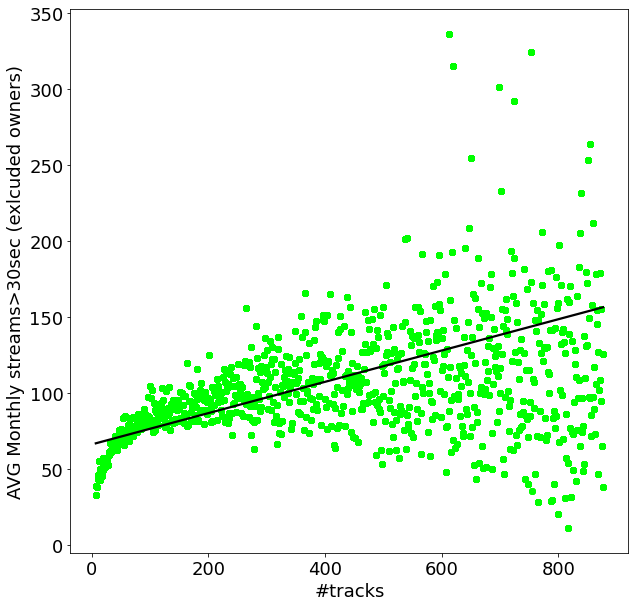

In [614]:
fig, ax = plt.subplots( figsize=(10, 10), sharey=True)
sns.regplot(x=df.loc[df.n_tracks<df.n_tracks.quantile(quantile)].n_tracks, 
            y=df.loc[df.n_tracks<df.n_tracks.quantile(quantile)].avg_monthly_stream30_track
           , color='lime', ax=ax, line_kws={"color": "black"}, ci=None)
plt.ylabel('AVG Monthly streams>30sec (exlcuded owners)')
plt.xlabel('#tracks')

Text(0.5, 0, '#albumns')

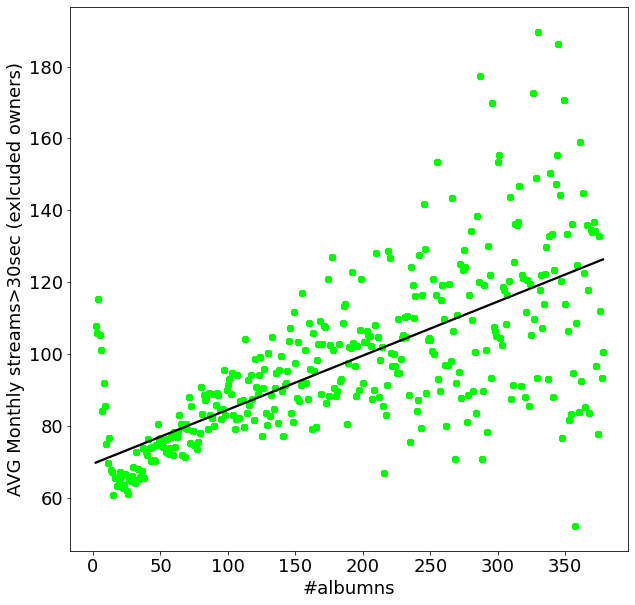

In [615]:
fig, ax = plt.subplots( figsize=(10, 10), sharey=True)
sns.regplot(x=df.loc[df.n_albums<df.n_albums.quantile(quantile)].n_albums, 
                y=df.loc[df.n_albums<df.n_albums.quantile(quantile)].avg_monthly_stream30_album, color='lime',
            line_kws={"color": "black"}, ci=None, ax=ax)
plt.ylabel('AVG Monthly streams>30sec (exlcuded owners)')
plt.xlabel('#albumns')

Text(0.5, 0, '#artists')

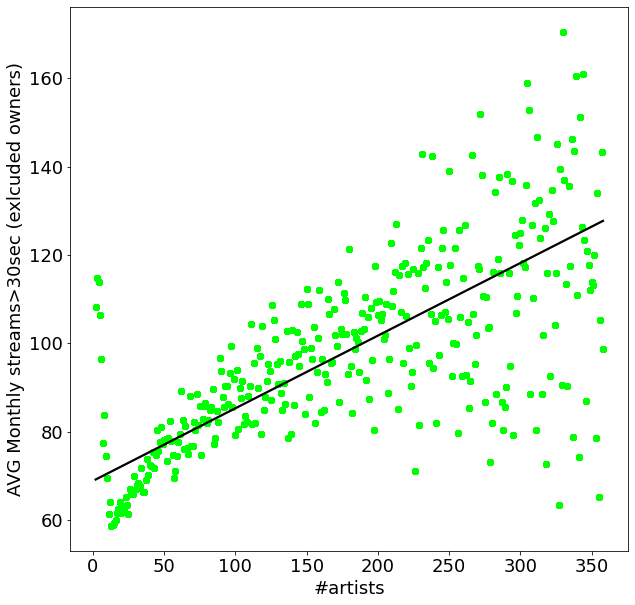

In [616]:
fig, ax = plt.subplots( figsize=(10, 10), sharey=True)
sns.regplot(x=df.loc[df.n_artists<df.n_artists.quantile(quantile)].n_artists, 
                y=df.loc[df.n_artists<df.n_artists.quantile(quantile)].avg_monthly_stream30_artist, color='lime',
            line_kws={"color": "black"}, ci=None, ax=ax)
plt.ylabel('AVG Monthly streams>30sec (exlcuded owners)')
plt.xlabel('#artists')

In [414]:
df.clean_monthly_stream30s.describe()

count   355567.000000
mean        78.071396
std        192.070322
min          1.000000
25%          7.000000
50%         22.000000
75%         65.000000
max       2377.000000
Name: clean_monthly_stream30s, dtype: float64

In [415]:
df.n_tracks.describe()

count   355567.000000
mean       163.869395
std        216.584895
min          7.000000
25%         42.000000
50%         88.000000
75%        192.000000
max       1870.000000
Name: n_tracks, dtype: float64

In [416]:
# fig, axes = plt.subplots(3, figsize=(10, 20), sharey=True)
# sns.scatterplot(x=df.n_tracks, y=df.clean_monthly_stream30s, color='lime', ax=axes[0])
# ax.ticklabel_format(style='plain')
# axes[0].set_xlabel('#tracks')
# axes[0].set_ylabel('')
# sns.scatterplot(x=df.n_artists, y=df.clean_monthly_stream30s, color='lime', ax=axes[1])
# axes[1].set_xlabel('#artists')
# axes[1].set_ylabel('')
# sns.scatterplot(x=df.n_albums, y=df.clean_monthly_stream30s, color='lime', ax=axes[2])
# axes[2].set_xlabel('#albumns')
# axes[2].set_ylabel('')
# fig.supylabel('Monthly streams>30sec (exlcuded owners)')

In [578]:
df['list_genres'] = df.apply(lambda x: [x['genre_1'], x['genre_2'], x['genre_3']], axis=1)

In [579]:
df['list_genres2']  = df['list_genres'].apply(lambda x: [el for el in x if el!='-'])

In [580]:
df['num_genres'] = df['list_genres2'].apply(lambda x: len(x) if x!=[''] else 0)

Text(0.5, 15.440000000000012, '#artists')

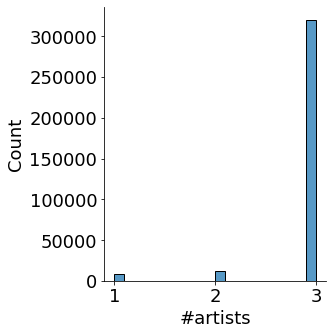

In [634]:
sns.displot(df['num_genres'])
plt.xlabel('#artists')

Text(0, 0.5, 'AVG Monthly streams>30sec (exlcuded owners)')

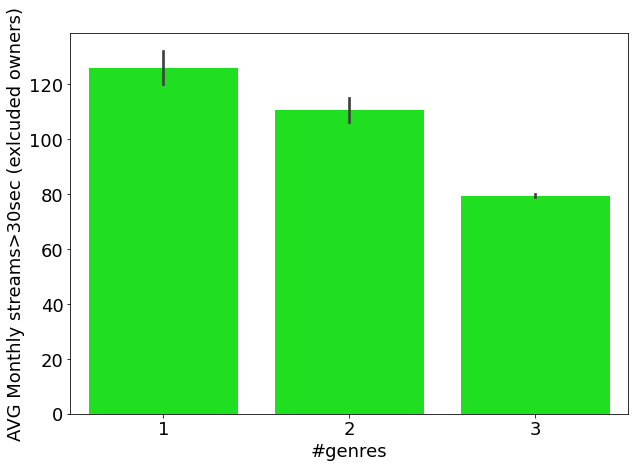

In [581]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x=df['num_genres'].astype(str), y=df.clean_monthly_stream30s, color='lime', order=['1', '2', '3'])
plt.xlabel('#genres')
plt.ylabel('AVG Monthly streams>30sec (exlcuded owners)')

In [582]:
df['list_moods'] = df.apply(lambda x: [x['mood_1'], x['mood_2'], x['mood_3']], axis=1)

In [583]:
df['list_moods2']  = df['list_moods'].apply(lambda x: [el for el in x if el!='-'])

In [584]:
df['num_moods'] = df['list_moods2'].apply(lambda x: len(x) if x!=[''] else 0)

Text(0, 0.5, 'AVG Monthly streams>30sec (exlcuded owners)')

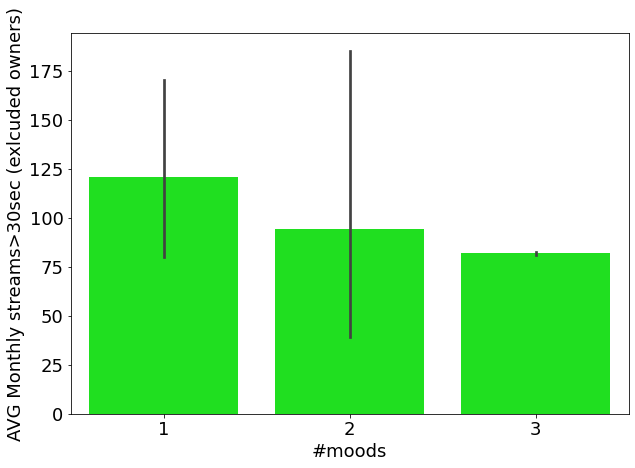

In [585]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x=df['num_moods'].astype(str), y=df.clean_monthly_stream30s, color='lime', 
                order=['1', '2', '3']
               )
plt.xlabel('#moods')
plt.ylabel('AVG Monthly streams>30sec (exlcuded owners)')

## Modeling

In [470]:
genres_moods = pd.get_dummies(df[['genre_1','mood_1', 'num_tockens_bin']])
genres_moods = genres_moods[['genre_1_Latin','genre_1_Spoken & Audio', "genre_1_Children's", 
'genre_1_Easy Listening', 'genre_1_Traditional','mood_1_Other', 'mood_1_Lively',  'mood_1_Tender',
'mood_1_Peaceful', 'mood_1_Romantic', 'num_tockens_bin_below 2', 'num_tockens_bin_higher/equal 2 and below 5',
       'num_tockens_bin_higher/equal than 5']]
data = pd.concat([df,genres_moods], axis = 1)

In [471]:
genres_moods = pd.get_dummies(df[['genre_1','mood_1', 'num_tockens_bin']])

In [472]:
len(df)

355567

In [473]:
df_sample = data.sample(15898).reset_index()

In [474]:
features = df_sample[[
   'mau_previous_month',
   'n_local_tracks',
   'n_tracks', 
   'n_local_tracks', 
   'n_artists', 
   'n_albums',
   'genre_1_Latin', 
    'genre_1_Spoken & Audio',
    "genre_1_Children's", 'genre_1_Easy Listening', 'genre_1_Traditional',
       'mood_1_Other', 'mood_1_Lively', 'mood_1_Tender', 'mood_1_Peaceful',
       'mood_1_Romantic',
   'num_tockens',
   'sentiment_score',
   'num_genres', 
   'num_moods']]

In [475]:
success_metric = df_sample.clean_monthly_stream30s

In [476]:
model = sm.OLS(success_metric, features)
fit_model = model.fit()
print(fit_model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     clean_monthly_stream30s   R-squared (uncentered):                   0.508
Model:                                 OLS   Adj. R-squared (uncentered):              0.508
Method:                      Least Squares   F-statistic:                              864.2
Date:                     Mon, 16 May 2022   Prob (F-statistic):                        0.00
Time:                             18:15:16   Log-Likelihood:                     -1.0204e+05
No. Observations:                    15898   AIC:                                  2.041e+05
Df Residuals:                        15879   BIC:                                  2.043e+05
Df Model:                               19                                                  
Covariance Type:                 nonrobust                                                  
                             coef    std err          t      P>|t|    

https://jyotiyadav99111.medium.com/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01

In [ ]:
15898